In [ ]:
import torch
import random

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [3]:
words = open('../names.txt').read().split()

In [ ]:
stoi = {s: i+1 for i, s in enumerate(sorted(set(''.join(words))))}
stoi['.'] = 0
itos = {s: i for i, s in stoi.items()}
itos

{1: 'a',
 2: 'b',
 3: 'c',
 4: 'd',
 5: 'e',
 6: 'f',
 7: 'g',
 8: 'h',
 9: 'i',
 10: 'j',
 11: 'k',
 12: 'l',
 13: 'm',
 14: 'n',
 15: 'o',
 16: 'p',
 17: 'q',
 18: 'r',
 19: 's',
 20: 't',
 21: 'u',
 22: 'v',
 23: 'w',
 24: 'x',
 25: 'y',
 26: 'z',
 0: '.'}

In [5]:

def build_dataset(words: list[str]):
    X, Y = [], []
    context_size = 3
    for w in words:
        context = [0] * context_size
        for ch in w + ".":
            X.append(context)
            Y.append(stoi[ch])
            # output = [itos[i] for i in context]
            # print(f"{''.join(output)} ----> {ch}")
            context = context[1:] + [stoi[ch]]
    return torch.tensor(X), torch.tensor(Y)


n1, n2 = int(0.8 * len(words)), int(0.9 * len(words))
random.shuffle(words)

X_train, Y_train = build_dataset(words=words[:n1])
X_dev, Y_dev = build_dataset(words=words[n1:n2])
X_test, Y_test = build_dataset(words=words[n2:])

X_train, Y_train = X_train.to(device=device), Y_train.to(device=device)
X_dev, Y_dev = X_dev.to(device=device), Y_dev.to(device=device)
X_test, Y_test = X_test.to(device=device), Y_test.to(device=device)

X_train.shape, X_dev.shape, X_test.shape

(torch.Size([182417, 3]), torch.Size([22928, 3]), torch.Size([22801, 3]))

In [6]:
g = torch.Generator(device=device).manual_seed(42)

In [7]:
C = torch.rand((27, 3), generator=g, device=device)
emb = C[X_train]
emb.shape

torch.Size([182417, 3, 3])

In [8]:
C = torch.empty((27, 5), device=device).uniform_(generator=g)
W1 = torch.empty((15, 200), device=device).uniform_(generator=g)
b1 = torch.empty(200,  device=device).uniform_(generator=g)
W2 = torch.empty((200, 27), device=device).uniform_(generator=g)
b2 = torch.empty(27, device=device).uniform_(generator=g)
parameters = [C, W1, b1, W2, b2]

In [9]:
sum(p.nelement() for p in parameters)

8762

In [10]:
for p in parameters:
    if p.dim() >= 2:
        torch.nn.init.kaiming_uniform_(p, generator=g)

In [11]:

for p in parameters:

    p.requires_grad = True

In [12]:
def forward(inputs):
    emb = C[inputs]
    h = torch.tanh(emb.view(-1, 15) @ W1+b1)
    logits = h @ W2 + b2
    return logits

In [13]:
n_iter = 10000
lre = torch.linspace(-3, 0, n_iter, device=device)
lrs = 10**lre
lrs[5000]

tensor(0.0316)

In [14]:
stepi, lossi, lossd = [], [], []

In [ ]:
n_iter = 10000
lre = torch.linspace(-3, 0, n_iter)
lrs = 10**lre

for i in range(n_iter + 1):

    # minibatch
    ix = torch.randint(0, X_train.shape[0], (32,), device=device)

    # emb = C[]
    inputs = X_train[ix]
    targets_training = Y_train[ix]
    logits_train = forward(inputs)
    loss_train = F.cross_entropy(logits_train, targets_training)

    logits_dev = forward(X_dev)
    loss_dev = F.cross_entropy(logits_dev, Y_dev)

    if i % 1000 == 0:
        print(f"step {i}  train loss: {
              loss_train:.4f}  dev loss: {loss_dev:.4f} ")

    for p in parameters:
        p.grad = None
    loss_train.backward()

    # updating gradient
    # lr = lrs[i] if i < 100000 else 0.0001
    lr = 0.1 if i < (n_iter//2) else 0.01
    for p in parameters:
        p.data += -lr * p.grad
    stepi.append(i)
    lossi.append(loss_train.log10().item())
    lossd.append(loss_dev.log10().item())

step 0  train loss: 4.9891  dev loss: 4.6680 
step 1000  train loss: 2.7293  dev loss: 2.5082 
step 2000  train loss: 2.4854  dev loss: 2.4460 
step 3000  train loss: 2.6325  dev loss: 2.4237 
step 4000  train loss: 2.2066  dev loss: 2.3854 
step 5000  train loss: 2.2640  dev loss: 2.3801 
step 6000  train loss: 2.7383  dev loss: 2.3226 
step 7000  train loss: 2.6902  dev loss: 2.3196 
step 8000  train loss: 2.5222  dev loss: 2.3172 
step 9000  train loss: 2.3578  dev loss: 2.3131 
step 10000  train loss: 2.4772  dev loss: 2.3113 


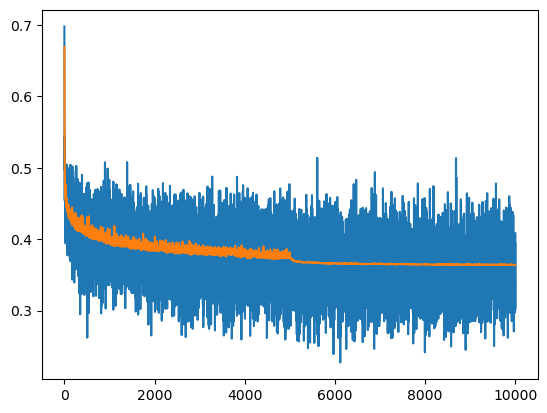

In [16]:
import matplotlib.pyplot as plt
plt.plot(stepi, lossi)
plt.plot(stepi, lossd)
plt.show()

In [101]:
import torch.nn.functional as F

expl_count = 20
for _ in range(expl_count):
    # context = [0]*2
    context = []
    context.extend(torch.multinomial(torch.arange(
        0, 26, dtype=torch.float32), num_samples=3, replacement=True, generator=g).tolist())
    output = []
    output.extend(context)
    # print(output)
    while True:
        result = F.softmax(forward(context), dim=1)
        new_token = torch.multinomial(
            result, num_samples=1, generator=g).item()
        context = context[1:] + [new_token]

        # print(context)
        output.append(new_token)
        if new_token == 0:
            break
    name = ''.join([itos[i] for i in output])
    print(name)

vvwlon.
xhroiah.
qqyn.
pnreez.
rgyaheynu.
msf.
usy.
trxl.
byvanneeszab.
wfteisorobin.
pmven.
plhaynu.
sciocergh.
rvgia.
ossa.
tiwani.
wmvalay.
npxldy.
xwkor.
audon.
